In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import pickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
#from pysynphot import observation
#from pysynphot import spectrum
import forwardmodel
import ciamod
import band

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
array = pickle.load(open("test_H2H2_H2He_CIA_H2O.pic", "rb")) 
leveltemp = array[0]
levelpress = array[1]
mikespec = np.array([array[2],array[3]],dtype='f')
mikespec[0] = 10000.0 / mikespec[0]
print levelpress.size
print levelpress

80
[  9.99999975e-05   1.20226425e-04   1.44543999e-04   1.73780092e-04
   2.08929574e-04   2.51188700e-04   3.01995198e-04   3.63077997e-04
   4.36515693e-04   5.24807489e-04   6.30957249e-04   7.58577778e-04
   9.12010903e-04   1.09647808e-03   1.31825637e-03   1.58489251e-03
   1.90546061e-03   2.29086843e-03   2.75422912e-03   3.31131113e-03
   3.98107106e-03   4.78629908e-03   5.75439911e-03   6.91830833e-03
   8.31763912e-03   9.99999978e-03   1.20226424e-02   1.44543927e-02
   1.73780080e-02   2.08929572e-02   2.51188558e-02   3.01995184e-02
   3.63078006e-02   4.36515696e-02   5.24807498e-02   6.30957261e-02
   7.58577362e-02   9.12010893e-02   1.09647810e-01   1.31825641e-01
   1.58489242e-01   1.90546066e-01   2.29086712e-01   2.75422752e-01
   3.31131101e-01   3.98107082e-01   4.78629917e-01   5.75439930e-01
   6.91830814e-01   8.31763446e-01   1.00000000e+00   1.20226419e+00
   1.44543922e+00   1.73779988e+00   2.08929467e+00   2.51188707e+00
   3.01995182e+00   3.63077998e

In [3]:
# set up coarse pressure grid and fine pressure grid
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
print finePress.size
print coarsePress.size
print finePress

64
13
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.011872

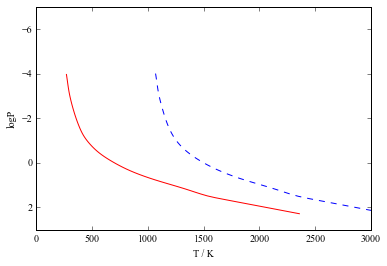

In [4]:
mikepress = np.empty(levelpress.size - 1,dtype='float64')
miketemp = np.empty(leveltemp.size -1, dtype='float64')
for i in range(0,mikepress.size):
    mikepress[i] = np.sqrt(levelpress[i] * levelpress[i+1])
mtfit = sp.interpolate.splrep(np.log10(levelpress),(leveltemp),s=10)
miketemp = sp.interpolate.splev(np.log10(mikepress),mtfit,der=0)
tfit = sp.interpolate.splrep(np.log10(mikepress),(miketemp),s=10)
temp = 800. +(np.asfortranarray(sp.interpolate.splev(np.log10(finePress),tfit,der=0),dtype='d'))

plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.,3000.,3.0,-7.0])
plt.plot(miketemp,np.log10(mikepress),'r-')
plt.plot(temp,np.log10(finePress),'b--')
plt.ylabel(r'logP')
plt.xlabel('T / K')

#

In [5]:
#intemp = np.loadtxt("16temps.dat",dtype='float32')
#intemp = np.full(16,1000.,dtype='f')
#inlayer = np.arange(0,15.25,1)  
#layer = np.arange(0,15.00,0.25)
#print layer.size
#tfit = interpolate.splrep(inlayer,intemp,s=0)
#temp = np.asfortranarray(interpolate.splev(layer,tfit, der=0),dtype='float32')
w1 = 1.0
w2 = 10.0
logg = 5.0
R2D2 = 1.0
#print inpress
#print mikepress

In [6]:
# Get the linelists
ngas = 10
gasnum = np.asfortranarray(np.array([1,4,7,8,10,11,3,2,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/h2s_xsecs.pic","../Linelists/ch4_xsecs.pic","../Linelists/K_Mike_xsecs.pic","../Linelists/Na_Mike_xsecs.pic"]

In [7]:
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
# Here we are interpolating the linelist onto our fine pressure scale. 
# let's only bother with the wavelength range of interest
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
print inpress.size
print inlinelist.shape
print nwave
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))


16
(16, 27, 19501)
9001


In [8]:
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))
linelist[np.isnan(linelist)] = -50.0
print linelist.shape
#print np.result_type(linelist)


(10, 64, 27, 9001)


In [9]:
VMR1 = np.full((npress,),(-3.5)) # water
vmr2 = np.full((npress,),(-3.4)) # ch4
vmr3 = np.full((npress,),(-7.5))  # CO
vmr4 = np.full((npress,),(-8.0)) # CO2
vmr5 = np.full((npress,),(-4.6)) # NH3
vmr6 = np.full((npress,),(-9.0))  # H2S
vmr7 = np.full((npress,),(-9.0))
vmr8 = np.full((npress,),(-9.0))
vmr9 = np.full((npress,),(-6.0)) # K
vmr10 = np.full((npress,),(-8.0)) # Na
#print VMR1.shape
logVMR = np.asfortranarray(np.reshape((VMR1,vmr2,vmr3,vmr4,vmr5,vmr6,vmr7,vmr8,vmr8,vmr9),(ngas,npress)),dtype='float64')
print logVMR.shape
press = finePress

(10, 64)


In [10]:
pcover = 1.0
do_clouds = 0
use_disort = 0
cloudnum = np.array([1],dtype='i')
#cloudname = np.reshape((cname),(1,1))
cloudrad = np.full((1,npress,1),1e-4)
cloudsig = np.full((1,npress,1),1e-5)
cloudprof = np.full((1,npress,1),0.0)

In [11]:
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')
print cia.shape
print ciatemps.shape
print cia.dtype

(4, 198, 9001)
(198,)
float32


In [12]:
tmpoutspec = forwardmodel.marv(temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort)
outspec = np.zeros((2,nwave),dtype='d')
outspec[:,:] = tmpoutspec[:,:nwave]

In [13]:
#np.savetxt("disort16stream_test.dat",np.c_[outspec[0,:],outspec[1,:]])
#print outspec



In [14]:
np.savetxt('10gas_TESTspectrum.dat', np.c_[outspec[0],outspec[1]])

In [ ]:
#B = np.empty(nwave,dtype='d') 
#B = 3.14159274*((2.*6.62606957e-34*(2.99792458e8**2.)) / ((outspec[0,:]*1.e-6)**5.)) / ((np.exp((6.62606957e-34*2.99792458e8)/(outspec[0,:]*1e-6*1.3806488e-23*1000.)))-1.) * 1.e-6
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.8, 2.5,0.0,5e5])
#oldspec = np.loadtxt("8gas_TESTspectrum.dat", unpack=True)
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.plot(oldspec[0,:],oldspec[1,:],'r-')
plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(outspec[0,:],(1.+ ((outspec[1,:]- oldspec[1,:])/outspec[1,:]))*1e5,'g-')

#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [ ]:
outspec =  outspec[:,np.logical_not(np.logical_or(outspec[0,:] > w2, outspec[0,:] < w1))]
wlen = outspec.shape[1]
wint = outspec[0,0] - outspec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))
print outspec.shape

In [ ]:
mikespec[1,:] = mikespec[1,:] / 1e6
mikespec =  mikespec[:,np.logical_not(np.logical_or(mikespec[0,:] > w2, mikespec[0,:] < w1))]
wlen = mikespec.shape[1]
wint = mikespec[0,0] - mikespec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))

In [ ]:
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel


In [ ]:
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(outspec[1,:],gauss,boundary='extend')
spec = np.array([outspec[0,::-1],cspec[::-1]])

In [ ]:
mgauss = Gaussian1DKernel(gwidth)
mcspec = convolve(mikespec[1,:],mgauss,boundary='extend')
mspec = np.array([mikespec[0,:],mcspec])

In [ ]:
print mspec[1]
print spec[1]

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0, 5.0, 0.,1.5e5])
plt.plot(mspec[0,:],mspec[1,:],'r-')
plt.plot(spec[0,:],spec[1,:],'b-')
#plt.plot(spec[0,:],mspec[1,:] / spec[1,:],'g-')
plt.ylabel(r'F_mike / F_ben')
plt.xlabel('Wavelength / Microns')


In [ ]:
# now resample
wavenew = np.arange(w1,w2,0.0015,dtype='f')
wfit = sp.interpolate.splrep(spec[0,:],spec[1,:],s=0)
binflux = sp.interpolate.splev(wavenew,wfit,der=0)
print binflux.size
print binflux

In [ ]:
speclen = binflux.size
unc = np.max(binflux[10::])
print unc /50
error = np.full(speclen,unc/50)
outflux = np.ones(speclen)
outflux = binflux + error*np.random.randn(speclen)
    

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.8, 6.5, 0.,10e4])
plt.plot(outspec[0,:],outspec[1,:],'r-')
#plt.plot(spec[0,:],spec[1,:],'b-')
plt.plot(wavenew,outflux,'b-')
plt.ylabel(r'$Flux$')
plt.xlabel('Wavelength / Microns')


In [ ]:
np.savetxt('5gas_spectrum.dat', np.c_[wavenew,outflux,error])

In [ ]:
gwidth = 4
if (gwidth % 2 == 0):
    gwidth = gwidth + 1

In [ ]:
print gwidth

In [ ]:
theta = [-3.45, -3.40]
fixvmr = -8.

In [ ]:
test = np.array([theta[0],theta[1], fixvmr]).reshape(3,)
print test

In [ ]:
ndim, nwalkers = 2, 4
p0 = -1.* np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) - 3.0
print p0.shape

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 3.5, 0.,25000])
bspec = np.loadtxt("sim_spectrum.dat", unpack="true")
plt.plot(bspec[0,:],bspec[1,:],'r-')
plt.plot(outspec[0,:],outspec[1,:],'b-')
#plt.plot(spec[0,:],mspec[1,:] / spec[1,:],'g-')
plt.ylabel(r'F_mike / F_ben')
plt.xlabel('Wavelength / Microns')


In [ ]:
# rebinning with the fancy method
# now rebin
wavenew = np.arange(w1,w2,0.0015,dtype='f')
ispec = spectrum.ArraySourceSpectrum(wave=spec[0,:], flux=spec[1,:])
f = np.ones(len(spec[0,:]))
filt = spectrum.ArraySpectralElement(spec[0,:], f, waveunits='microns')
obs = observation.Observation(ispec, filt, binset=wavenew, force='taper')
print obs.binflux.shape

In [ ]:
speclen = obs.binflux.size
unc = np.max(obs.binflux)
error = np.full(speclen,unc/50)
outflux = np.ones(speclen)
outflux = obs.binflux + error*np.random.randn(speclen)
    

In [ ]:
s = 1e-18
print s**2

In [ ]:
fresh = 2
if (fresh != 0):
    print "balls"

In [ ]:
fresh = 0
nwalkers = 200
ndim= 25
obspec = np.asfortranarray(np.loadtxt("G570D_2MHcalib.dat",dtype='d',unpack='true'))

p0 = np.empty([nwalkers,ndim])
if (fresh == 0):
    p0[:,0] = (0.5*np.random.randn(nwalkers).reshape(nwalkers)) - 3.5 # H2O
    p0[:,1] = (0.5*np.random.randn(nwalkers).reshape(nwalkers)) - 3.5 # CH4
    p0[:,2] = (0.5*np.random.randn(nwalkers).reshape(nwalkers)) - 7.5 # CO
    p0[:,3] = (0.5*np.random.randn(nwalkers).reshape(nwalkers)) - 8.0 # CO2
    p0[:,4] = (0.5*np.random.randn(nwalkers).reshape(nwalkers)) - 4.6 # NH3
    p0[:,5] = (0.5*np.random.randn(nwalkers).reshape(nwalkers)) - 9.0  #H2S
    p0[:,6] = (0.5*np.random.randn(nwalkers).reshape(nwalkers)) - 5.5  # Na+K
    p0[:,7] = np.random.rand(nwalkers).reshape(nwalkers) + 4.2
    p0[:,8] =  1.5e-19 + (np.random.randn(nwalkers).reshape(nwalkers) * 1.e-20)
    p0[:,9] = np.random.randn(nwalkers).reshape(nwalkers) * 0.01
    #p0[:,5] = np.log10((np.random.rand(nwalkers).reshape(nwalkers) * (min(obspec[2,10::3]**2)*(0.1 - 0.001))) + (0.001*min(obspec[2,10::3]**2)))
    p0[:,10] =  50. + (np.random.randn(nwalkers).reshape(nwalkers))
    p0[:,11] = np.log10((np.random.rand(nwalkers).reshape(nwalkers) * (max(obspec[2,:]**2)*(10. - 0.01))) + (0.01*min(obspec[2,10::3]**2)))

    #p0[:,6] = 200. + ( np.random.rand(nwalkers).reshape(nwalkers) * 100. )
    BTprof = np.loadtxt("BTtemp800_45_13.dat")
    for i in range(0,13):
        p0[:,i+12] = (BTprof[i] - 200.) + (150. * np.random.randn(nwalkers).reshape(nwalkers))
print p0[1:5,:]